# Monte Carlo Portfolio Optimization

This notebook handles data acquisition, loading, and comprehensive analysis for portfolio optimization using Monte Carlo simulations.

## 1. Setup and Configurations

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create data directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

## 2. Data Acquisition

Fetching adjusted close prices for selected assets.

In [11]:
tickers = ["AAPL", "MSFT", "GOOGL", "SPY"]

print("Downloading data...")
data = yf.download(
    tickers,
    start="2020-01-01",
    end="2025-12-31",
    auto_adjust=True,
    progress=False
)

# Handle Multi-Index columns
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"]

data_to_save = data.reset_index()
output_path = "../data/asset_prices.csv"
data_to_save.to_csv(output_path, index=False)

print(f"✅ Saved: {output_path}")
data.head()

✅ Saved: ../data/asset_prices.csv


Ticker,AAPL,GOOGL,MSFT,SPY
Date,,,,
2020-01-02,72.400513,67.920815,152.505707,297.698883
2020-01-03,71.696632,67.565475,150.606735,295.444733
2020-01-06,72.267937,69.366386,150.995987,296.571838
2020-01-07,71.928040,69.232399,149.619293,295.737915
2020-01-08,73.085121,69.725174,152.002441,297.314117


## 3. Data Loading & Preprocessing

In [12]:
def load_processed_data(file_path):
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    return df

prices = load_processed_data("../data/asset_prices.csv")
print("Data loaded successfully.")

Data loaded successfully.


## 4. Return Analysis & Statistical Properties

In [13]:
# 1. Calculate Daily Log Returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# 2. Annualized Mean Return & Volatility (assuming 252 trading days)
annual_return = log_returns.mean() * 252
annual_volatility = log_returns.std() * np.sqrt(252)

stats_df = pd.DataFrame({
    'Annual Return': annual_return,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': annual_return / annual_volatility
})

print("Statistical Properties of Asset Returns:")
display(stats_df)

Statistical Properties of Asset Returns:


,Annual Return,Annual Volatility,Sharpe Ratio
AAPL,0.221984,0.317487,0.699189
GOOGL,0.256112,0.324797,0.788528
MSFT,0.194446,0.295464,0.658105
SPY,0.139933,0.208008,0.672729


## 5. Visualizations

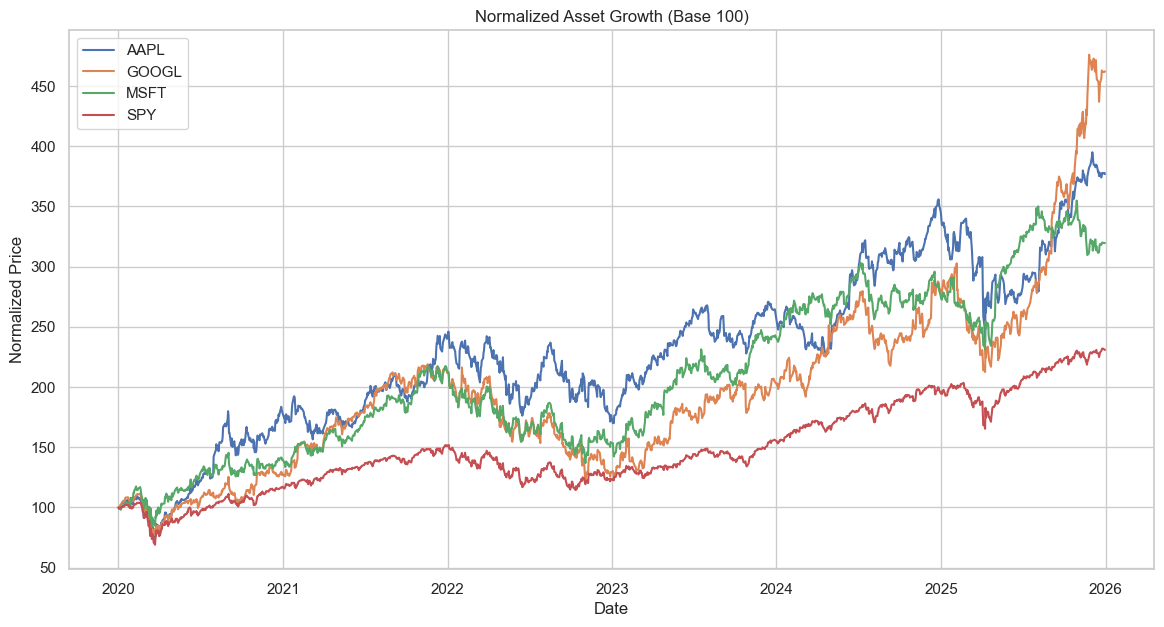

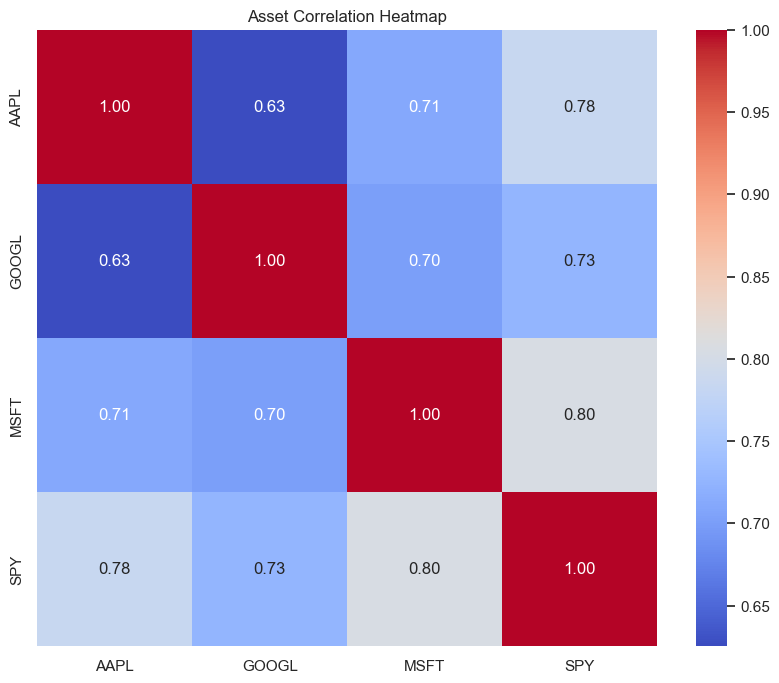

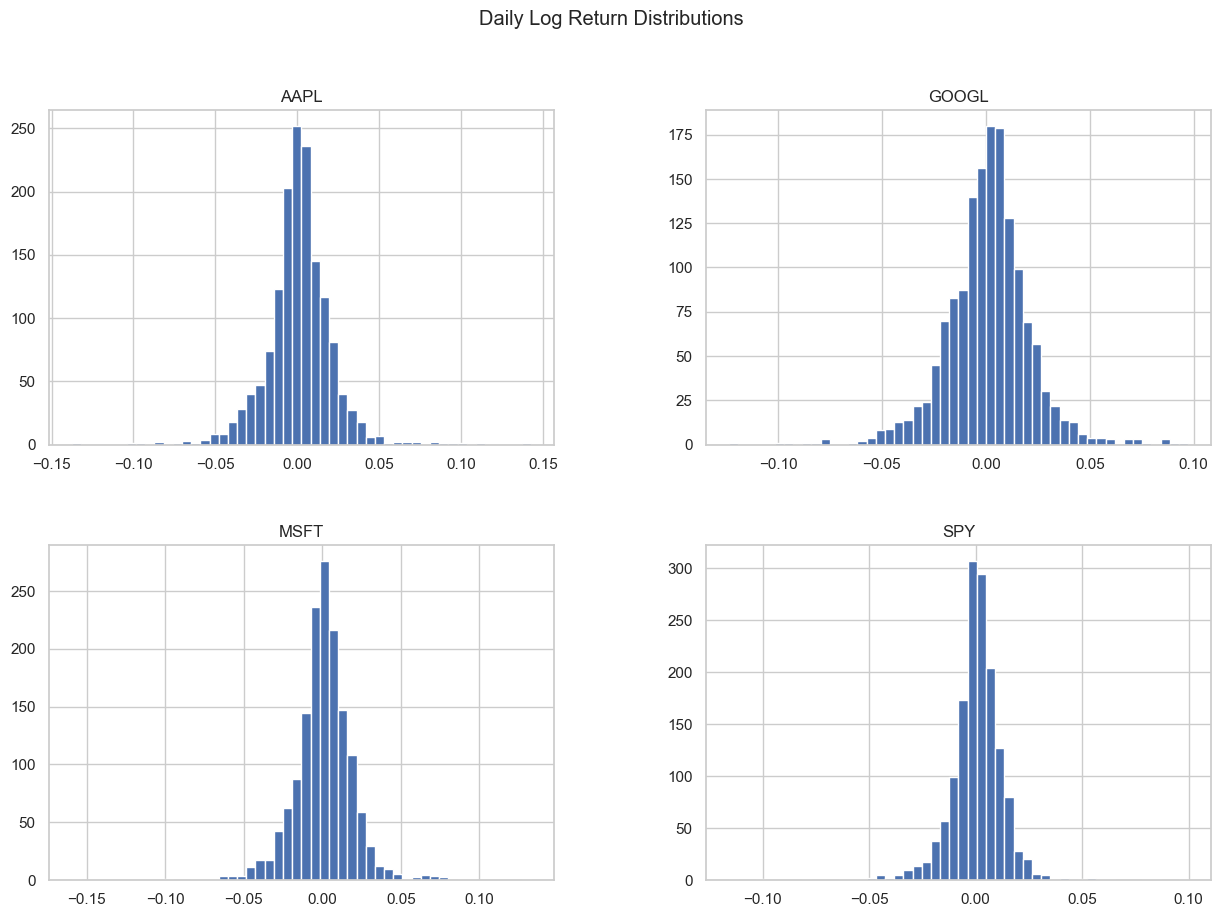

In [14]:
# Normalize prices to start at 100 for comparison
normalized_prices = (prices / prices.iloc[0]) * 100

plt.figure(figsize=(14, 7))
for asset in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[asset], label=asset)

plt.title("Normalized Asset Growth (Base 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Asset Correlation Heatmap")
plt.show()

# Return Distributions
log_returns.hist(bins=50, figsize=(15, 10))
plt.suptitle("Daily Log Return Distributions")
plt.show()

### 5.1 Drawdown Curve

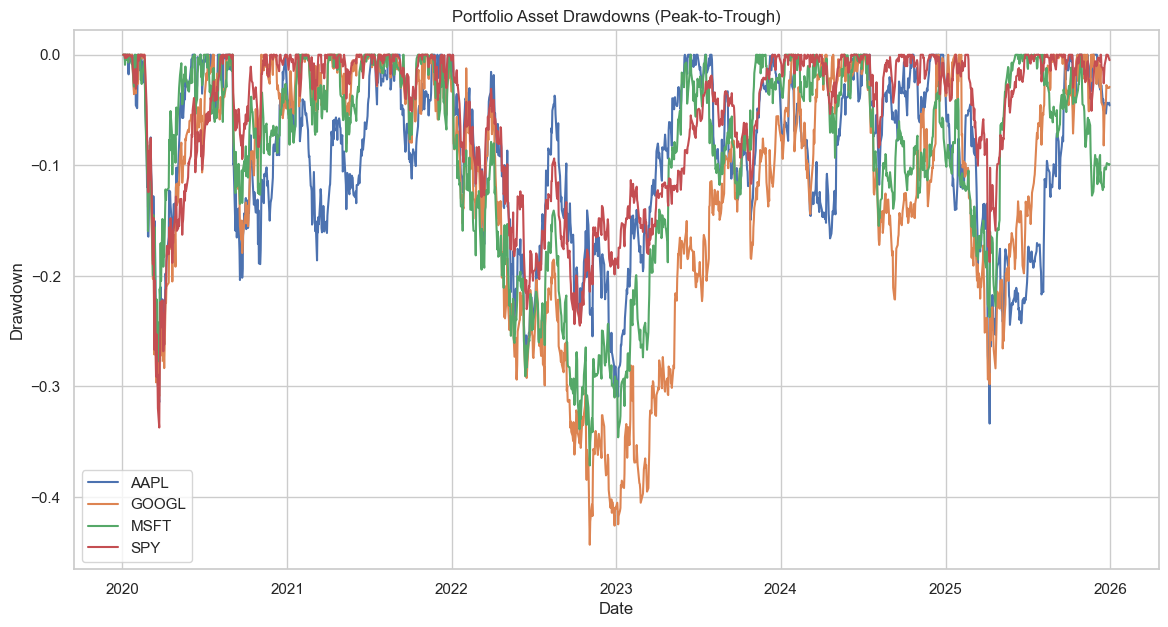

In [15]:
cumulative_returns = (1 + log_returns).cumprod()
peak = log_returns.cumsum().apply(np.exp).expanding(min_periods=1).max()
drawdown = (log_returns.cumsum().apply(np.exp) / peak) - 1

plt.figure(figsize=(14, 7))
for asset in drawdown.columns:
    plt.plot(drawdown.index, drawdown[asset], label=asset)

plt.title("Portfolio Asset Drawdowns (Peak-to-Trough)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

## 6. Monte Carlo Simulation for Portfolio Optimization

In [16]:
num_portfolios = 10000
all_weights = np.zeros((num_portfolios, len(tickers)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[i, :] = weights
    
    # Expected Return
    ret_arr[i] = np.sum((log_returns.mean() * weights) * 252)
    
    # Expected Volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

max_sharpe_idx = sharpe_arr.argmax()
print(f"Best Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}")
print(f"Weights for Optimal Portfolio: {dict(zip(tickers, all_weights[max_sharpe_idx, :]))}")

Best Sharpe Ratio: 0.83
Weights for Optimal Portfolio: {'AAPL': np.float64(0.3305776051736372), 'MSFT': np.float64(0.5948342997474476), 'GOOGL': np.float64(0.05182632789756757), 'SPY': np.float64(0.022761767181347634)}


## 7. Efficient Frontier Visualization

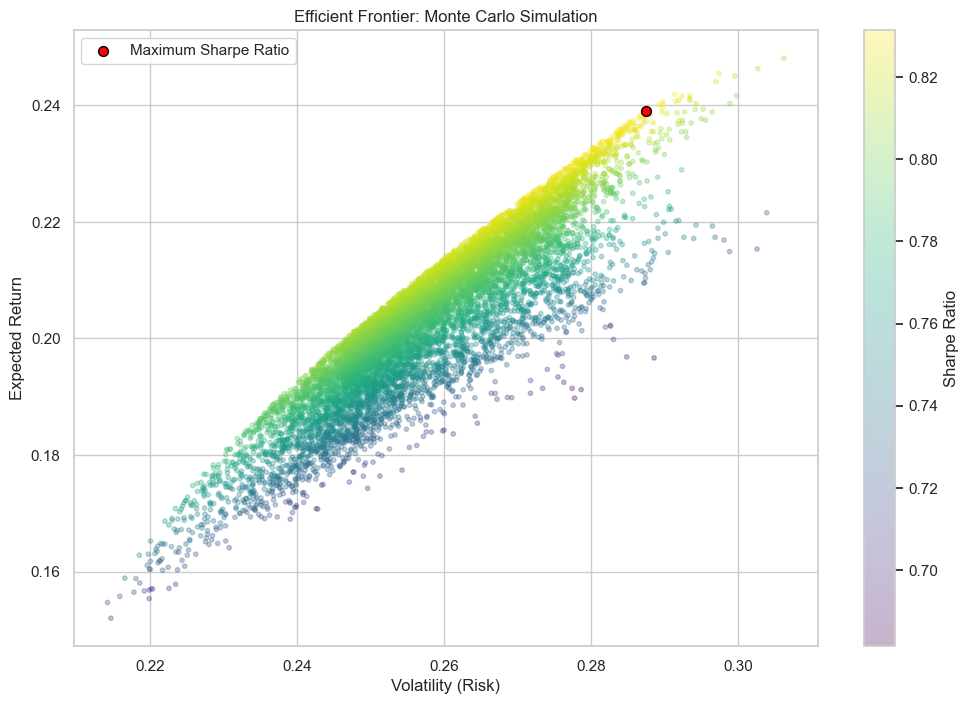

In [17]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], c='red', s=50, edgecolors='black', label='Maximum Sharpe Ratio')

plt.title('Efficient Frontier: Monte Carlo Simulation')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()